# Predicting manufacturing yield using finite element analysis (FEA) and ML  
## HDD VCMs

#### Goal: Prevent bad lots from being built by predicting performance distribution (i.e., motor torque, retract torque) as a function of sub-component lot to lot variability.  Customer defines the output spec and the factory controls incoming parts to meet this spec.  

#### Method: Build ML model based on motor features with motor torque as output variable; transform feature variable to be more relevant to output variable, i.e. true position, perform Monte Carlo simulation to produce output distribution to analyze percentage of parts falling outside tolerance zone. However some problems were encountered causing poor model performance.  These we due in part to parts where centered to close to the mean, measurement variability, human resource limitations.  An alternative method was developed by constructing virtual parts using FEA-Ansys and feed feature variables into ML model to predict motor torque.
   

## Method1 - physical parts

<img src="./images/physical_prt.png" alt="physical" title="phys_part" width="800"/>

## Method2 - virtual parts FEA

<img src="./images/cad_fea.png" alt="cad_fea" title="CAD to FEA" width="800"/>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from numpy.random import normal
from numpy.random import seed
%matplotlib inline

In [5]:
data_x = pd.read_csv("./data/features_x.csv")
data_y = pd.read_csv("./data/output_kt.csv")
#data_y = pd.read_csv("./data/output_rt.csv")

## Exploratory data analysis

In [6]:
data = pd.concat([data_x, data_y], axis=1)
data.head()

,total_flux,nz_width_top,nz_width_btm,mag_irad_top,mag_irad_btm,nz_pos_top,nz_pos_btm,dat_z_top,dat_z_btm,plt_thk_top,plt_thk_btm,air_gap,spacer_dst,kt_max
0,449.8304,0.7554,0.8464,12.3395,12.4318,-0.026200,-0.065700,10.0740,5.8755,4.1225,4.1230,4.1985,52.529127,88.687155
1,447.6383,0.9507,0.9758,12.3164,12.2339,-0.023200,-0.050400,10.0640,5.8680,4.1095,4.1195,4.1960,52.526690,88.460333
2,448.3690,0.8862,0.9319,12.3926,12.3317,-0.044133,-0.016933,10.0605,5.8780,4.1260,4.1115,4.1825,52.529384,88.687155
3,446.9076,0.8145,0.9581,12.3269,12.2835,-0.025200,-0.043533,10.0750,5.8670,4.1365,4.1175,4.2080,52.529792,88.233512
4,446.9076,0.8874,0.8490,12.3445,12.2022,-0.019100,-0.036833,10.0740,5.8670,4.1010,4.1270,4.2070,52.508001,88.460333


In [7]:
data.describe()

,total_flux,nz_width_top,nz_width_btm,mag_irad_top,mag_irad_btm,nz_pos_top,nz_pos_btm,dat_z_top,dat_z_btm,plt_thk_top,plt_thk_btm,air_gap,spacer_dst,kt_max
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,449.510719,0.836181,0.912931,12.343881,12.320019,-0.027984,-0.034975,10.073156,5.873953,4.115875,4.121969,4.199203,52.528129,88.736772
std,1.779589,0.061527,0.041496,0.043094,0.055570,0.010876,0.013823,0.008266,0.006975,0.009229,0.010881,0.009667,0.009164,0.319397
min,446.907600,0.716600,0.806400,12.247200,12.202200,-0.047767,-0.065700,10.058500,5.862000,4.094000,4.101000,4.174000,52.505411,88.233512
25%,447.455625,0.806150,0.894925,12.321150,12.284850,-0.036783,-0.043533,10.068500,5.867875,4.111000,4.114875,4.194250,52.526636,88.460333
50%,450.561100,0.824200,0.912050,12.346450,12.331750,-0.025700,-0.037300,10.074000,5.874500,4.116750,4.122500,4.202000,52.529818,88.687155
75%,451.291800,0.870175,0.932600,12.364100,12.351600,-0.020150,-0.025917,10.079000,5.878500,4.122125,4.130625,4.204625,52.533024,88.913976
max,451.291800,1.012300,0.998600,12.430100,12.431800,-0.009300,-0.006600,10.091000,5.888000,4.136500,4.140000,4.216000,52.541036,89.594440


In [8]:
corr_mx = data.corr()
corr_mx

,total_flux,nz_width_top,nz_width_btm,mag_irad_top,mag_irad_btm,nz_pos_top,nz_pos_btm,dat_z_top,dat_z_btm,plt_thk_top,plt_thk_btm,air_gap,spacer_dst,kt_max
total_flux,1.000000,0.049973,-0.095426,-0.190151,0.137639,0.010142,0.024322,0.215814,0.127882,0.058482,0.191792,0.092271,0.193826,0.188711
nz_width_top,0.049973,1.000000,0.193996,-0.073258,-0.469629,0.148517,0.065420,-0.134498,0.212878,-0.031430,0.233572,-0.268608,-0.165947,-0.283702
nz_width_btm,-0.095426,0.193996,1.000000,-0.119403,-0.286326,0.154833,-0.125937,-0.219431,0.026776,-0.069719,0.176473,-0.206955,-0.112138,-0.191629
mag_irad_top,-0.190151,-0.073258,-0.119403,1.000000,-0.115852,-0.136005,0.027367,0.181977,0.271371,0.127568,0.214458,-0.040195,-0.051992,0.136210
mag_irad_btm,0.137639,-0.469629,-0.286326,-0.115852,1.000000,-0.208088,0.084351,-0.008672,-0.113870,0.228242,-0.346296,0.074745,0.366086,0.252443
nz_pos_top,0.010142,0.148517,0.154833,-0.136005,-0.208088,1.000000,-0.042434,-0.121812,-0.166926,-0.180782,0.155394,0.016282,-0.318883,-0.154407
nz_pos_btm,0.024322,0.065420,-0.125937,0.027367,0.084351,-0.042434,1.000000,-0.234948,-0.149376,-0.082210,-0.199153,-0.093123,0.016789,0.016172
dat_z_top,0.215814,-0.134498,-0.219431,0.181977,-0.008672,-0.121812,-0.234948,1.000000,0.204063,-0.039271,0.156242,0.707860,0.091390,-0.065386
dat_z_btm,0.127882,0.212878,0.026776,0.271371,-0.113870,-0.166926,-0.149376,0.204063,1.000000,-0.160323,0.344249,-0.547041,0.226522,0.002720
plt_thk_top,0.058482,-0.031430,-0.069719,0.127568,0.228242,-0.180782,-0.082210,-0.039271,-0.160323,1.000000,0.088294,0.082098,0.013601,0.134967


<AxesSubplot:>

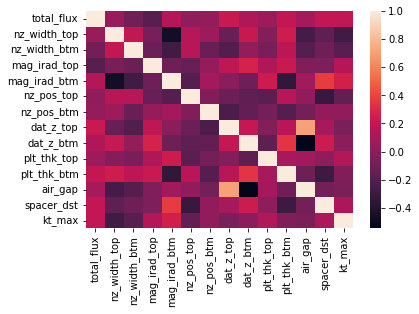

In [9]:
sns.heatmap(data.corr())

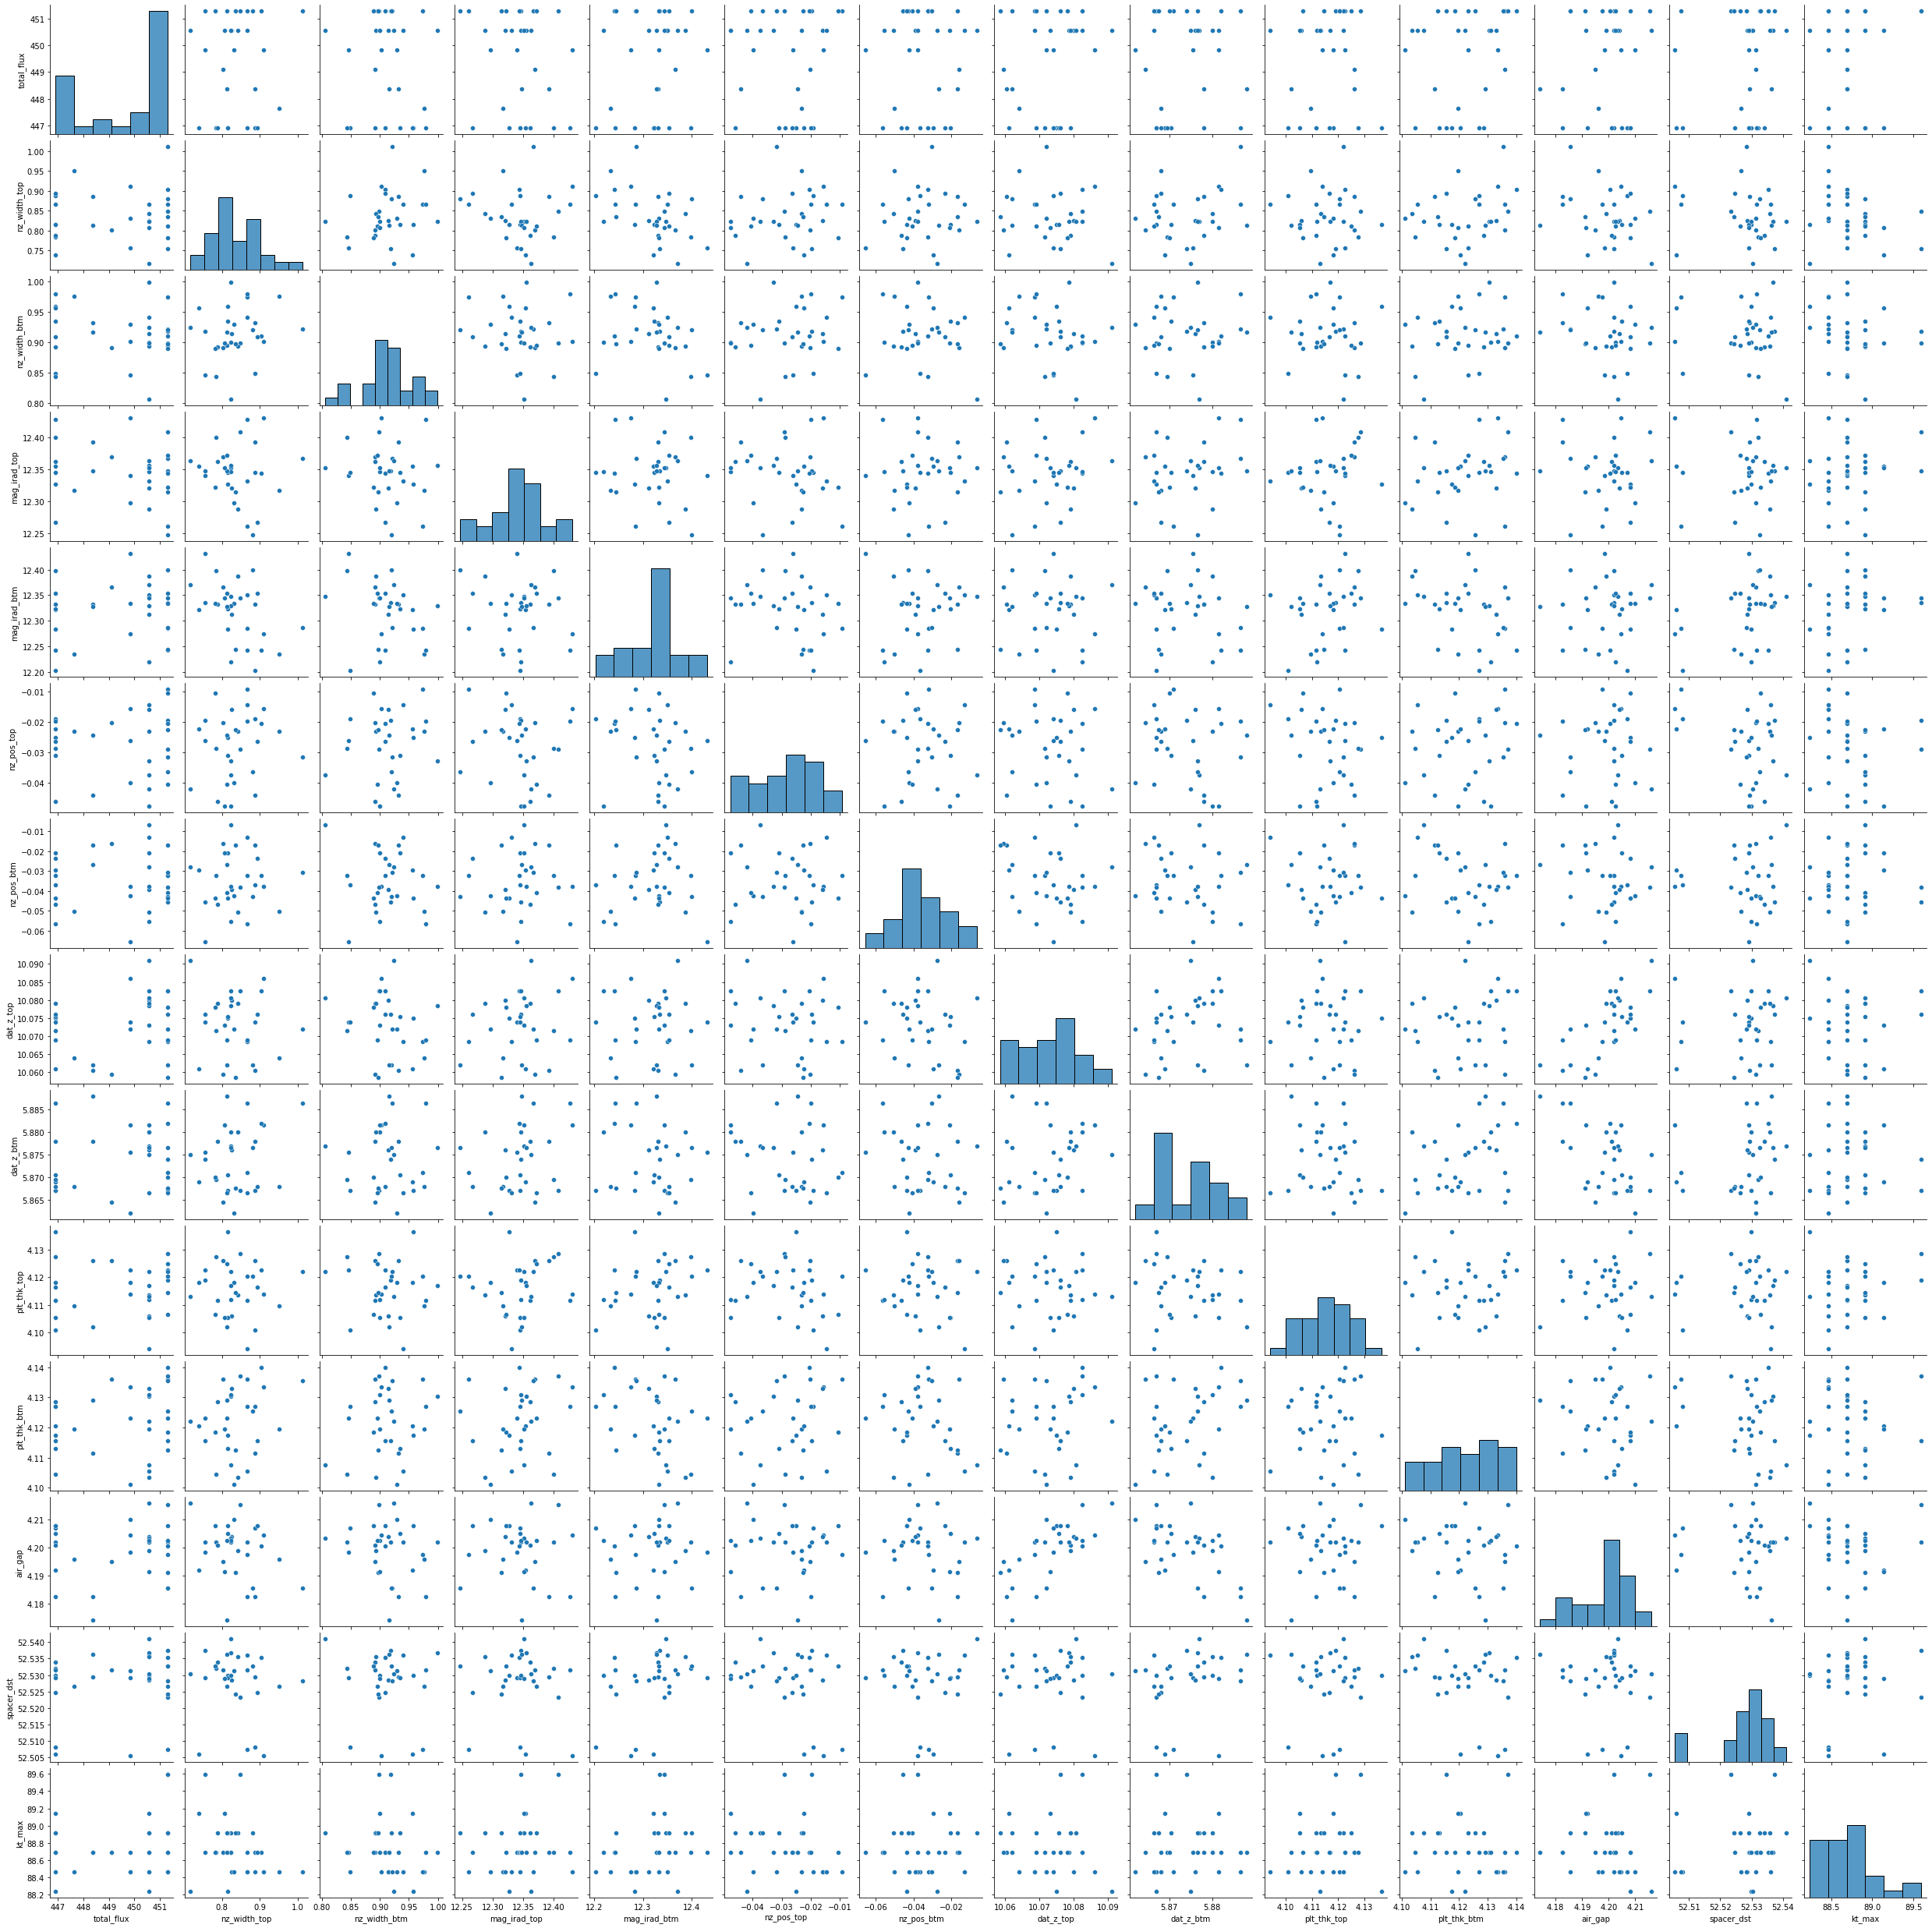

In [10]:
sns.pairplot(data)

In [11]:
#randonmize and split data into training and test
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.18, random_state=303)

## Linear regression model

In [12]:
model = sm.OLS(y_train, sm.add_constant(X_train)).fit() #added a column of 1s for intercept
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 kt_max   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                 -0.412
Method:                 Least Squares   F-statistic:                    0.3920
Date:                Mon, 06 Jun 2022   Prob (F-statistic):              0.943
Time:                        11:30:25   Log-Likelihood:                -3.6939
No. Observations:                  26   AIC:                             33.39
Df Residuals:                      13   BIC:                             49.74
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           91.5092    558.351      0.164      0.872   -1114.734    1297.753
total_flux       0.0406      0.056      0.727      0.480      -0.080       0.161
nz_width_top    -1.6759      1.469     -1.141      0.275      -4.850       1.498
nz_width_btm    -1.0595      2.433     -0.436      0.670      -6.315       4.196
mag_irad_top     0.9888      2.123      0.466      0.649      -3.599       5.576
mag_irad_btm     0.5081      2.002      0.254      0.804      -3.818       4.834
nz_pos_top       0.2962      8.350      0.035      0.972     -17.742      18.334
nz_pos_btm      -4.4537      7.108     -0.627      0.542     -19.809      10.902
dat_z_top       -5.6603      8.835     -0.641      0.533     -24.747      13.426
dat_z_btm       -2.6074     10.101     -0.258      0.800     -24.429      19.214
plt_thk_top      7.2042     11.177      0.645      0.530     -16.942      31.350
plt_thk_btm     -0.0955      9.677     -0.010      0.992     -21.001      20.810
air_gap         -3.0529      6.014     -0.508      0.620     -16.046       9.940
spacer_dst       0.3556     10.431      0.034      0.973     -22.179      22.890
==============================================================================
Omnibus:                        1.471   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.479   Jarque-Bera (JB):                0.670
Skew:                           0.381   Prob(JB):                        0.715
Kurtosis:                       3.193   Cond. No.                     3.45e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.49e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [13]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

print(f'Intercept: {regr.intercept_}')
print(f'Coefficients: {regr.coef_}')

Intercept: [82.16319575]
Coefficients: [[ 4.01858479e-02 -1.70528591e+00 -1.05247170e+00  8.99375981e-01
   5.52879912e-01 -4.77033094e-02 -4.34095731e+00  1.28616873e+13
  -1.28616873e+13  7.19458728e+00  2.07415926e-01 -1.28616873e+13
   5.69804008e-01]]


In [14]:
regr.score(X_train, y_train)

0.2591074737811956

In [15]:
MAE_regr_test = np.array(abs(regr.predict(X_test) - y_test)).mean() 
MAE_regr_test

0.26436733777987814

## Random Forest and Adaboost regression trees

In [16]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import KFold 

In [17]:
#hyperparameter optimization of n_estimators using 5 fold CV

folds = 5
kf = KFold(folds)
score_rf = []
score_adabst = []


for i in range(25, 300, 25):
    sum_mae_rf = 0
    sum_mae_adabst = 0
    rf = RandomForestRegressor(n_estimators = i, random_state = 42)
    adabst = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators = i, random_state=42)

    for train_index, val_index in kf.split(X_train):
        X_trn , X_val = np.array(X_train)[train_index,:], np.array(X_train)[val_index,:]
        y_trn , y_val = np.ravel(y_train)[train_index] , np.ravel(y_train)[val_index]  
        
        rf.fit(X_trn, y_trn)
        pred_rf = rf.predict(X_val)
        MAE_rf = np.mean(abs(pred_rf - y_val))
        sum_mae_rf += MAE_rf
        
        adabst.fit(X_trn, y_trn)
        pred_adabst = adabst.predict(X_val)
        MAE_adabst = np.mean(abs(pred_adabst - y_val))
        sum_mae_adabst += MAE_adabst
        
    score_rf.append(sum_mae_rf/folds) 
    score_adabst.append(sum_mae_adabst/folds)

In [35]:
#cv scores for each #of trees
#[score_rf, score_adabst]

Text(0.5, 0, 'No. of Trees')

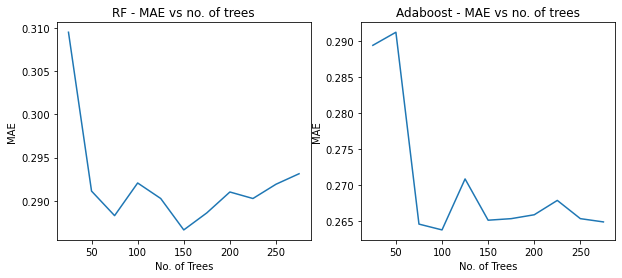

In [19]:
%matplotlib inline
plt.figure(figsize = (10,4))
plt.subplot(121)
plt.plot(range(25, 300, 25), score_rf)
plt.title('RF - MAE vs no. of trees')
plt.ylabel('MAE')
plt.xlabel('No. of Trees')
plt.subplot(122)
plt.plot(range(25, 300, 25), score_adabst)
plt.title('Adaboost - MAE vs no. of trees')
plt.ylabel('MAE')
plt.xlabel('No. of Trees')

In [20]:
#Use optimized values for n_estimators and find MAE test scores for both tree models
rf_best = RandomForestRegressor(n_estimators=150, random_state=42)
adabst_best = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators=100, random_state=42)

rf_best.fit(np.array(X_train), np.ravel(y_train))
pred_rf_best = rf_best.predict(np.array(X_test))
MAE_rf_best = np.mean(abs(pred_rf_best - np.ravel(y_test)))

adabst_best.fit(np.array(X_train), np.ravel(y_train))
pred_adabst_best = adabst_best.predict(np.array(X_test))
MAE_adabst_best = np.mean(abs(pred_adabst_best - np.ravel(y_test)))


## Test MAE results - Physical parts

In [21]:
#test MAE
pd.DataFrame({'MAE RandF': [MAE_rf_best], 'MAE Adabst': [MAE_adabst_best], 'MAE Linear R':[MAE_regr_test]})

,MAE RandF,MAE Adabst,MAE Linear R
0,0.260593,0.232222,0.264367


## Alternative Method - Virtual Parts

In [22]:
ansys_df = pd.read_csv('./data/ansys_kt.csv')

In [23]:
ansys_X = ansys_df.iloc[ : , :-1]
ansys_y = ansys_df.iloc[ : , -1] 
X_train, X_test, y_train, y_test = train_test_split(ansys_X, ansys_y, test_size=0.18, random_state=303)

In [25]:

df = pd.concat([data.iloc[ : , -1], ansys_y], axis=1)
df.columns = ['physical parts kt', 'ansys kt']
#df

Text(0.5, 0, 'motor torque')

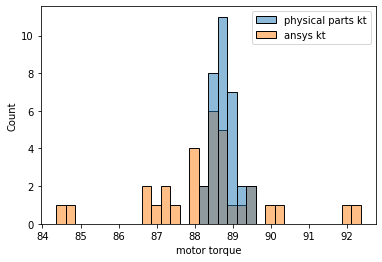

In [26]:
ax = sns.histplot(df, binwidth = 0.25) 
ax.set_xlabel('motor torque')

In [27]:
model_ansys = sm.OLS(y_train, sm.add_constant(X_train)).fit()
model_ansys.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Kt Max   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     2454.
Date:                Mon, 06 Jun 2022   Prob (F-statistic):           1.60e-23
Time:                        11:32:11   Log-Likelihood:                 46.839
No. Observations:                  27   AIC:                            -71.68
Df Residuals:                      16   BIC:                            -57.42
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     10.8806     17.008      0.640      0.531     -25.174      46.936
Magnet Thickness          27.9567      0.290     96.304      0.000      27.341      28.572
Magnet Corner Radius      -0.5613      0.097     -5.801      0.000      -0.766      -0.356
Plate Thickness            1.8416      0.145     12.687      0.000       1.534       2.149
Magnet Profile             8.3005      0.097     85.780      0.000       8.095       8.506
Magnet Material Br         5.5256      0.073     76.137      0.000       5.372       5.679
NZ Width                   0.1717      0.139      1.238      0.234      -0.122       0.466
Magnet Radial Pos          1.7673      0.139     12.747      0.000       1.473       2.061
Magnet Circum Pos         -0.0372      0.055     -0.671      0.512      -0.155       0.080
Top Magnet NZ Shift       -0.0020      0.065     -0.030      0.976      -0.141       0.137
Bottom Magnet NZ Shift     0.0020      0.065      0.030      0.976      -0.137       0.141
Spacer Pin Height         -9.4000      1.569     -5.992      0.000     -12.725      -6.075
==============================================================================
Omnibus:                        3.166   Durbin-Watson:                   2.317
Prob(Omnibus):                  0.205   Jarque-Bera (JB):                2.060
Skew:                          -0.471   Prob(JB):                        0.357
Kurtosis:                       2.028   Cond. No.                     2.54e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.48e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [28]:
regr_ansys = linear_model.LinearRegression()
regr_ansys.fit(X_train, y_train)

print(f'Intercept: {regr_ansys.intercept_}')
print(f'Coefficients: {regr_ansys.coef_}')

Intercept: 10.880627926595821
Coefficients: [ 2.79567419e+01 -5.61295094e-01  1.84156362e+00  8.30050753e+00
  5.52560174e+00  1.71675900e-01  1.76734859e+00 -3.72008250e-02
 -1.95611667e-03  1.95611667e-03 -9.40000000e+00]


##Coef of determination Rsquared (Train, Test): 1 - RSS/TSS

In [37]:
[regr_ansys.score(X_train, y_train), regr_ansys.score(X_test, y_test)]

[0.9993484533670459, 0.9662373579860609]

## Test MAE - Virtual parts

In [30]:
MAE = np.mean(abs(regr_ansys.predict(X_test) - np.array(y_test)))
MSE = np.mean(np.power(regr_ansys.predict(X_test) - np.array(y_test), 2))
pd.DataFrame({'MAE LinearR Ansys':[MAE]})

,MAE LinearR Ansys
0,0.081922


## Monte Carlo Simulation

In [31]:
pred_dist = {'Magnet Thickness': (3.25, 3.30, 3.35), 
             'Magnet Corner Radius': (0.1, 0.25, 0.4), 
             'Plate Thickness': (4.0, 4.1, 4.2),
             'Magnet Profile': (-0.15, 0, 0.15),
             'Magnet Material Br': (14.1, 14.3, 14.5),
             'NZ Width': (1.6, 1.8, 2.0),
             'Magnet Radial Pos': (-0.2, 0, 0.2),
             'Magnet Circum Pos': (-0.5, 0, 0.5),
             'Top Magnet NZ Shift': (-0.3, 0, 0.3),
             'Bottom Magnet NZ Shift': (-0.3, 0, 0.3),
             'Spacer Pin Height': (10.775, 10.8, 10.825)}

In [38]:
seed(303)
n_pred = 11
n_sigma = 3.5
arr = np.zeros(n_pred)

def get_sample(pred_dist, arr, n_sigma):
    output = arr.copy()
    for i, key in enumerate(pred_dist.keys()):
        output[i] = normal(loc = pred_dist[key][1], scale = (pred_dist[key][1] - pred_dist[key][0]) / n_sigma, size=1)  #scale is stdev
    return output    

def montecarlo_sim(n, pred_dist, arr, n_sigma, model = regr_ansys):
    results = []
    for i in range(n): 
        sample = get_sample(pred_dist, arr, n_sigma)
        y = sample @ model.coef_ + model.intercept_
        results.append(y)
    return results    
 

<img src="./images/distrib_x.png" alt="dist_x" title="distx" width="1000"/>

In [39]:
torque = montecarlo_sim(100000, pred_dist, arr, n_sigma, regr_ansys)

Text(0.5, 1.0, 'Monte Carlo Simulation')

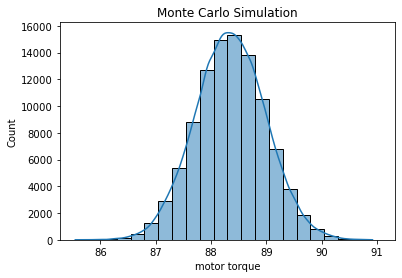

In [40]:
ax = sns.histplot(torque, kde=True, binwidth = 0.25) 
ax.set_xlabel('motor torque')
ax.set_title('Monte Carlo Simulation')

<img src="./images/montecarlo.png" alt="monte_carlo" title="MC" width="1000"/>

## Summary
extensions: if lots are trending outside of tolerance zone, we can run the monte carlo simulation with different distrubutions to bring motor torque back into spec, i.e. request sub-supplier to increase or decrease magnet thickness

FEA and ML is still relatively new technique but there have been recent publications  

extensions: cost reduction analysis, design boundaries analysis